# 作业2：使用ResNet34模型对Fashion-MNIST数据集进行分类

绘制精度曲线

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet34
import matplotlib.pyplot as plt
import os

# 定义训练函数
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy

# 定义测试函数
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / total
    return test_loss, test_accuracy

/home/Akex/.conda/envs/DL-Akex-torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Akex/.conda/envs/DL-Akex-torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Train Loss: 0.5907, Train Accuracy: 78.07%, Test Loss: 0.5819, Test Accuracy: 79.22%
Epoch 2: Train Loss: 0.3883, Train Accuracy: 85.81%, Test Loss: 0.3934, Test Accuracy: 85.18%
Epoch 3: Train Loss: 0.3322, Train Accuracy: 87.86%, Test Loss: 0.3359, Test Accuracy: 87.38%
Epoch 4: Train Loss: 0.2971, Train Accuracy: 89.03%, Test Loss: 0.2977, Test Accuracy: 89.05%
Epoch 5: Train Loss: 0.2810, Train Accuracy: 89.74%, Test Loss: 0.3208, Test Accuracy: 88.05%
Epoch 6: Train Loss: 0.2630, Train Accuracy: 90.31%, Test Loss: 0.3315, Test Accuracy: 88.01%
Epoch 7: Train Loss: 0.2527, Train Accuracy: 90.65%, Test Loss: 0.2446, Test Accuracy: 90.92%
Epoch 8: Train Loss: 0.2395, Train Accuracy: 91.22%, Test Loss: 0.2580, Test Accuracy: 90.59%
Epoch 9: Train Loss: 0.2288, Train Accuracy: 91.60%, Test Loss: 0.2347, Test Accuracy: 91.47%
Epoch 10: Train Loss: 0.2217, Train Accuracy: 91.93%, Test Loss: 0.2371, Test Accuracy: 91.54%
Epoch 11: Train Loss: 0.2182, Train Accuracy: 91.97%, Test 

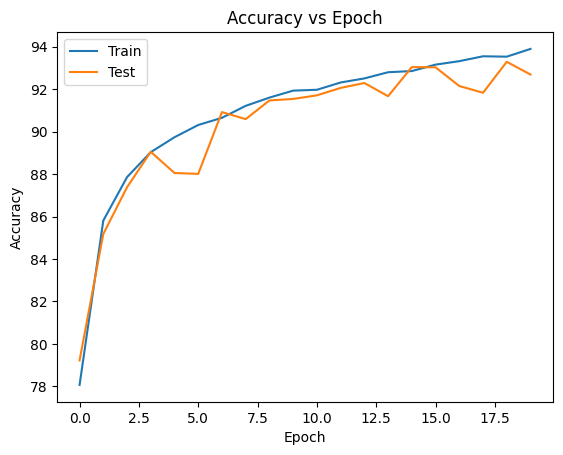

In [18]:
# 定义主函数
def test1():
    # 加载Fashion-MNIST数据集
    # train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor())
    # test_dataset = datasets.FashionMNIST(root='./data/', train=False, transform=transforms.ToTensor())
    # 使用transforms对数据集进行标准化
    # mean = train_dataset.data.float().mean() / 255
    # print(mean) # tensor(0.2860)
    # std = train_dataset.data.float().std() / 255
    # print(std) # tensor(0.3530)

    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
        # transforms.RandomRotation(10),
        # transforms.RandomErasing(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
    train_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=False, transform=transform_test)
    # 定义模型
    model = resnet34(weights=None)  # 加载预训练模型
    num_classes = 10
    in_channels = 1  # 输入通道数为1
    model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # 更改最后一层全连接层

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    batch_size = 128
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

    for epoch in range(30):
        if (epoch + 1) % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader, criterion)

        print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # 绘制精度曲线
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

    # 绘制损失曲线
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()


test1()

cuda
Epoch 1: Train Loss: 0.5242, Train Accuracy: 80.86%, Test Loss: 0.3537, Test Accuracy: 87.48%
Epoch 2: Train Loss: 0.3602, Train Accuracy: 86.64%, Test Loss: 0.3114, Test Accuracy: 88.40%
Epoch 3: Train Loss: 0.3210, Train Accuracy: 88.06%, Test Loss: 0.2797, Test Accuracy: 90.00%
Epoch 4: Train Loss: 0.2968, Train Accuracy: 89.13%, Test Loss: 0.2837, Test Accuracy: 89.92%
Epoch 5: Train Loss: 0.2798, Train Accuracy: 89.77%, Test Loss: 0.2590, Test Accuracy: 90.66%
Epoch 6: Train Loss: 0.2638, Train Accuracy: 90.12%, Test Loss: 0.2271, Test Accuracy: 91.67%
Epoch 7: Train Loss: 0.2523, Train Accuracy: 90.57%, Test Loss: 0.2278, Test Accuracy: 91.98%
Epoch 8: Train Loss: 0.2439, Train Accuracy: 90.87%, Test Loss: 0.2783, Test Accuracy: 90.17%
Epoch 9: Train Loss: 0.2384, Train Accuracy: 91.09%, Test Loss: 0.2148, Test Accuracy: 92.09%
Epoch 10: Train Loss: 0.1853, Train Accuracy: 93.06%, Test Loss: 0.1880, Test Accuracy: 93.31%
Epoch 11: Train Loss: 0.1739, Train Accuracy: 93.47%, 

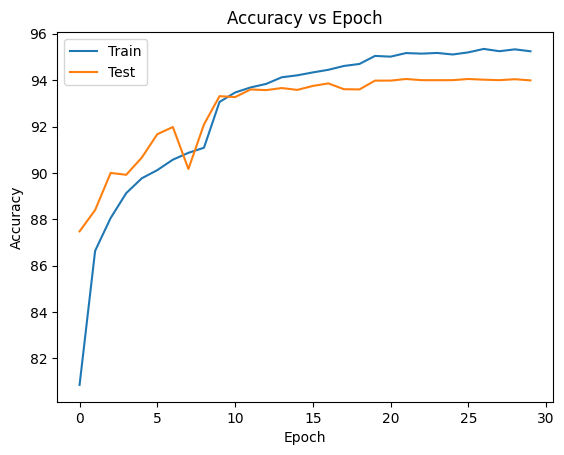

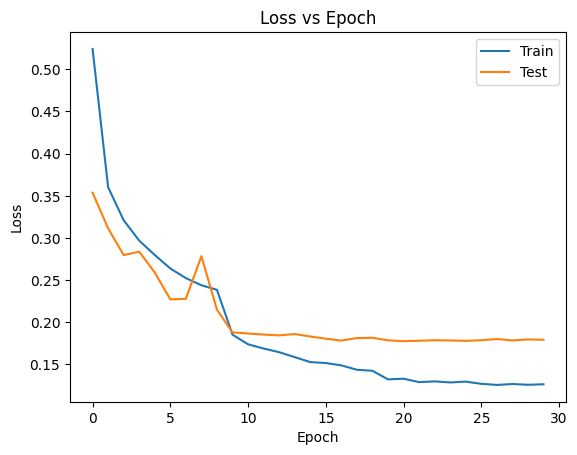

In [5]:
# 定义主函数
def test2():
    # 加载Fashion-MNIST数据集
    # train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor())
    # test_dataset = datasets.FashionMNIST(root='./data/', train=False, transform=transforms.ToTensor())
    # 使用transforms对数据集进行标准化
    # mean = train_dataset.data.float().mean() / 255
    # print(mean) # tensor(0.2860)
    # std = train_dataset.data.float().std() / 255
    # print(std) # tensor(0.3530)

    transform_train = transforms.Compose([
        # transforms.RandomCrop(28, padding=4),
        # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,)),
        transforms.RandomRotation(5),
        transforms.RandomErasing()
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
    train_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=False, transform=transform_test)
    # 定义模型
    model = resnet34(weights=None)  # 加载预训练模型
    num_classes = 10
    in_channels = 1  # 输入通道数为1
    model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # 更改最后一层全连接层

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

    for epoch in range(40):
        if (epoch + 1) % 10 == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.1
        train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader, criterion)

        print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # 绘制精度曲线
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

    # 绘制损失曲线
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()


test2()

cuda
Epoch 1: Train Loss: 0.6968, Train Accuracy: 74.00%, Test Loss: 0.5453, Test Accuracy: 79.45%
Epoch 2: Train Loss: 0.4847, Train Accuracy: 82.19%, Test Loss: 0.4318, Test Accuracy: 83.22%
Epoch 3: Train Loss: 0.4248, Train Accuracy: 84.48%, Test Loss: 0.3931, Test Accuracy: 86.07%
Epoch 4: Train Loss: 0.3991, Train Accuracy: 85.69%, Test Loss: 0.3403, Test Accuracy: 87.85%
Epoch 5: Train Loss: 0.3786, Train Accuracy: 86.27%, Test Loss: 0.4055, Test Accuracy: 85.59%
Epoch 6: Train Loss: 0.3646, Train Accuracy: 86.75%, Test Loss: 0.2865, Test Accuracy: 89.56%
Epoch 7: Train Loss: 0.3507, Train Accuracy: 87.17%, Test Loss: 0.3087, Test Accuracy: 88.86%
Epoch 8: Train Loss: 0.3409, Train Accuracy: 87.67%, Test Loss: 0.2863, Test Accuracy: 89.64%
Epoch 9: Train Loss: 0.3346, Train Accuracy: 87.87%, Test Loss: 0.2980, Test Accuracy: 89.02%
Epoch 10: Train Loss: 0.3263, Train Accuracy: 88.04%, Test Loss: 0.2756, Test Accuracy: 90.48%
Epoch 11: Train Loss: 0.3154, Train Accuracy: 88.39%, 

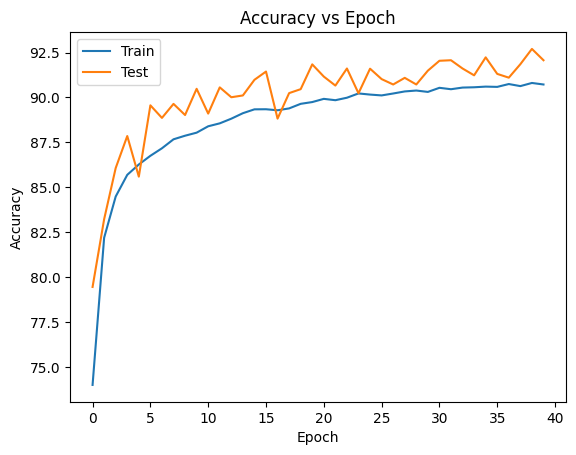

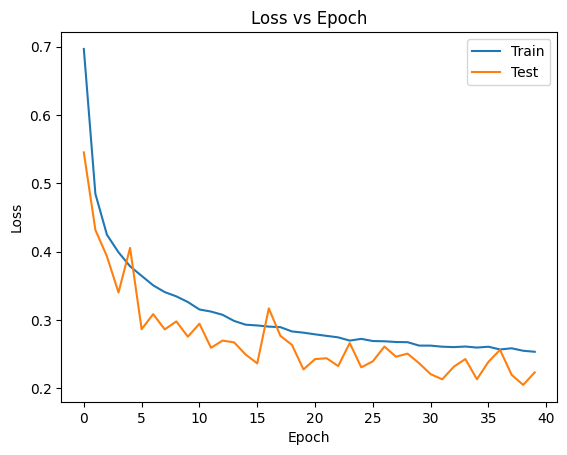

In [6]:
# 定义主函数
def test3():
    # 加载Fashion-MNIST数据集
    # train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor())
    # test_dataset = datasets.FashionMNIST(root='./data/', train=False, transform=transforms.ToTensor())
    # 使用transforms对数据集进行标准化
    # mean = train_dataset.data.float().mean() / 255
    # print(mean) # tensor(0.2860)
    # std = train_dataset.data.float().std() / 255
    # print(std) # tensor(0.3530)

    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,)),
        transforms.RandomErasing()
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
    train_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=False, transform=transform_test)
    # 定义模型
    model = resnet34(weights=None)  # 加载预训练模型
    num_classes = 10
    in_channels = 1  # 输入通道数为1
    model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # 更改最后一层全连接层

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    train_batch_size = 128
    test_batch_size = 100
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=6)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=6)

    model = model.to(device)
    # model = torch.nn.DataParallel(model).cuda()
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

    for epoch in range(60):
        if (epoch + 1) % 10 == 0:
            scheduler.step()
        train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader, criterion)
        # if (epoch + 1) % 3 == 0:
        #     torch.save(model.state_dict(), '/home/Akex/LiGe-homework/homework2/checkpoints/checkpoint-{}-{}.pt'.format(epoch+1,test_accuracy))
        print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # 绘制精度曲线
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

    # 绘制损失曲线
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()


test3()

mps
Epoch 1: Train Loss: 0.7031, Train Accuracy: 74.15%, Test Loss: 0.4594, Test Accuracy: 84.01%
Epoch 2: Train Loss: 0.4801, Train Accuracy: 82.64%, Test Loss: 0.3993, Test Accuracy: 85.12%
Epoch 3: Train Loss: 0.4327, Train Accuracy: 84.30%, Test Loss: 0.3842, Test Accuracy: 85.70%
Epoch 4: Train Loss: 0.4037, Train Accuracy: 85.33%, Test Loss: 0.5190, Test Accuracy: 80.37%
Epoch 5: Train Loss: 0.3832, Train Accuracy: 86.09%, Test Loss: 0.4587, Test Accuracy: 85.11%
Epoch 6: Train Loss: 0.3660, Train Accuracy: 86.73%, Test Loss: 0.2889, Test Accuracy: 89.77%
Epoch 7: Train Loss: 0.3537, Train Accuracy: 87.08%, Test Loss: 0.3175, Test Accuracy: 87.94%
Epoch 8: Train Loss: 0.3427, Train Accuracy: 87.45%, Test Loss: 0.3471, Test Accuracy: 87.20%
Epoch 9: Train Loss: 0.3344, Train Accuracy: 87.82%, Test Loss: 0.3035, Test Accuracy: 88.62%
Epoch 10: Train Loss: 0.3241, Train Accuracy: 88.24%, Test Loss: 0.3579, Test Accuracy: 87.18%
Epoch 11: Train Loss: 0.2635, Train Accuracy: 90.35%, T

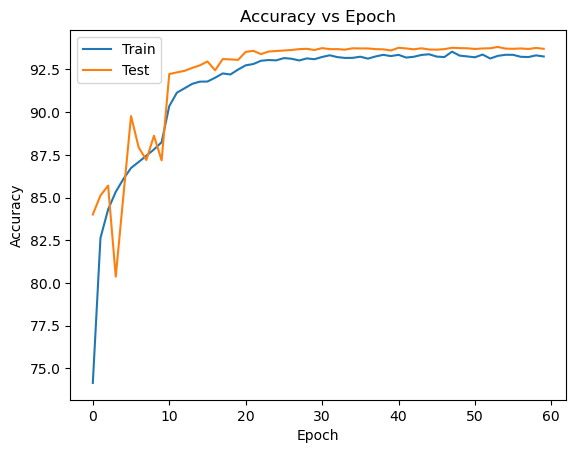

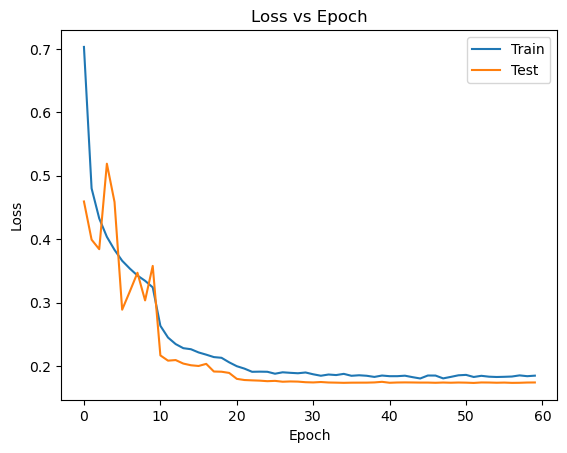

In [5]:
# 定义主函数
def test4():
    # 加载Fashion-MNIST数据集
    # train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor())
    # test_dataset = datasets.FashionMNIST(root='./data/', train=False, transform=transforms.ToTensor())
    # 使用transforms对数据集进行标准化
    # mean = train_dataset.data.float().mean() / 255
    # print(mean) # tensor(0.2860)
    # std = train_dataset.data.float().std() / 255
    # print(std) # tensor(0.3530)

    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,)),
        transforms.RandomErasing()
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
    # train_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=True, transform=transform_train)
    # test_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=False, transform=transform_test)
    train_dataset = datasets.FashionMNIST(root='./data/', download=False, train=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root='./data/', download=False, train=False, transform=transform_test)
    # 定义模型
    model = resnet34(weights=None)  # 加载预训练模型
    num_classes = 10
    in_channels = 1  # 输入通道数为1
    model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # 更改最后一层全连接层

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    print(device)
    train_batch_size = 128
    test_batch_size = 100
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=4)

    model = model.to(device)
    # model = torch.nn.DataParallel(model).cuda()
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

    for epoch in range(60):

        train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
        scheduler.step()
        test_loss, test_accuracy = test(model, device, test_loader, criterion)
        if (epoch + 1) % 3 == 0:
            if not os.path.exists('./checkpoints'):
                os.makedirs('./checkpoints/')
            # torch.save(model.state_dict(), '/home/Akex/LiGe-homework/homework2/checkpoints/checkpoint-{}-{}.pt'.format(epoch+1,test_accuracy))
            torch.save(model.state_dict(), './checkpoints/checkpoint-{}-{}.ckpt'.format(epoch+1,test_accuracy))
        print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # 绘制精度曲线
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

    # 绘制损失曲线
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()


test4()

cuda
Epoch 1: Train Loss: 0.7687, Train Accuracy: 71.27%, Test Loss: 0.5746, Test Accuracy: 78.94%
Epoch 2: Train Loss: 0.5542, Train Accuracy: 79.61%, Test Loss: 0.4034, Test Accuracy: 85.80%
Epoch 3: Train Loss: 0.5028, Train Accuracy: 81.78%, Test Loss: 0.4222, Test Accuracy: 84.52%
Epoch 4: Train Loss: 0.4734, Train Accuracy: 82.67%, Test Loss: 0.4255, Test Accuracy: 84.53%
Epoch 5: Train Loss: 0.4515, Train Accuracy: 83.41%, Test Loss: 0.3957, Test Accuracy: 84.78%
Epoch 6: Train Loss: 0.4389, Train Accuracy: 83.90%, Test Loss: 0.3517, Test Accuracy: 87.33%
Epoch 7: Train Loss: 0.4205, Train Accuracy: 84.83%, Test Loss: 0.3425, Test Accuracy: 87.51%
Epoch 8: Train Loss: 0.4034, Train Accuracy: 85.17%, Test Loss: 0.3527, Test Accuracy: 87.19%
Epoch 9: Train Loss: 0.3985, Train Accuracy: 85.25%, Test Loss: 0.3452, Test Accuracy: 87.79%
Epoch 10: Train Loss: 0.3917, Train Accuracy: 85.68%, Test Loss: 0.3472, Test Accuracy: 87.15%
Epoch 11: Train Loss: 0.3228, Train Accuracy: 88.12%, 

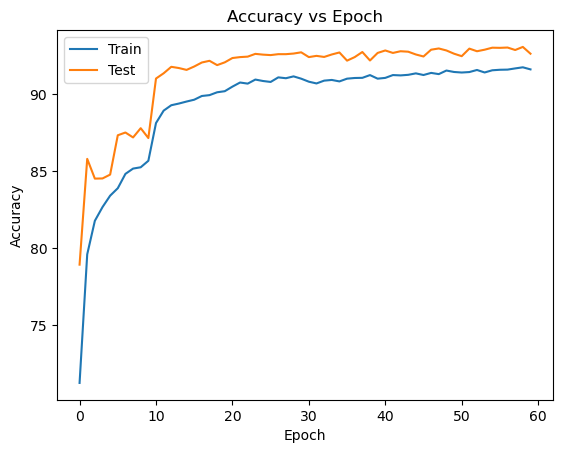

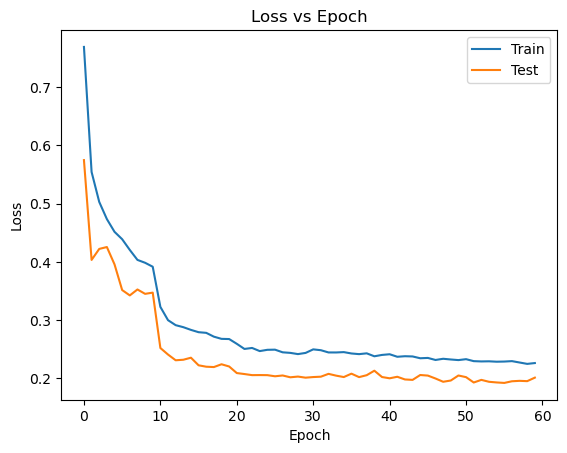

In [4]:
# 定义主函数
def test5():
    # 加载Fashion-MNIST数据集
    # train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor())
    # test_dataset = datasets.FashionMNIST(root='./data/', train=False, transform=transforms.ToTensor())
    # 使用transforms对数据集进行标准化
    # mean = train_dataset.data.float().mean() / 255
    # print(mean) # tensor(0.2860)
    # std = train_dataset.data.float().std() / 255
    # print(std) # tensor(0.3530)

    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,)),
        transforms.RandomErasing()
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
    # train_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=True, transform=transform_train)
    # test_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=False, transform=transform_test)
    train_dataset = datasets.FashionMNIST(root='./data/', download=False, train=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root='./data/', download=False, train=False, transform=transform_test)
    # 定义模型
    model = resnet34(weights=None)  # 加载预训练模型
    num_classes = 10
    in_channels = 1  # 输入通道数为1
    model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # 更改最后一层全连接层

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    print(device)
    train_batch_size = 128
    test_batch_size = 100
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=6)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=6)

    model = model.to(device)
    model = torch.nn.DataParallel(model).cuda()
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

    for epoch in range(60):
        if epoch == 30:
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
            # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
        if epoch < 30:
            scheduler.step()
        test_loss, test_accuracy = test(model, device, test_loader, criterion)
        if (epoch + 1) % 3 == 0:
            if not os.path.exists('./checkpoints'):
                os.makedirs('./checkpoints/')
            # torch.save(model.state_dict(), '/home/Akex/LiGe-homework/homework2/checkpoints/checkpoint-{}-{}.pt'.format(epoch+1,test_accuracy))
            torch.save(model.state_dict(), './checkpoints/checkpoint-{}-{}.ckpt'.format(epoch+1,test_accuracy))
        print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # 绘制精度曲线
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

    # 绘制损失曲线
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()


test5()

cuda
Epoch 1: Train Loss: 0.7675, Train Accuracy: 71.43%, Test Loss: 0.6977, Test Accuracy: 72.86%
Epoch 2: Train Loss: 0.5578, Train Accuracy: 79.51%, Test Loss: 0.4740, Test Accuracy: 83.60%
Epoch 3: Train Loss: 0.4977, Train Accuracy: 81.88%, Test Loss: 0.3965, Test Accuracy: 85.28%
Epoch 4: Train Loss: 0.4667, Train Accuracy: 82.91%, Test Loss: 0.4347, Test Accuracy: 84.70%
Epoch 5: Train Loss: 0.4506, Train Accuracy: 83.63%, Test Loss: 0.3350, Test Accuracy: 88.50%
Epoch 6: Train Loss: 0.4304, Train Accuracy: 84.22%, Test Loss: 0.3849, Test Accuracy: 85.89%
Epoch 7: Train Loss: 0.4169, Train Accuracy: 84.76%, Test Loss: 0.3551, Test Accuracy: 87.28%
Epoch 8: Train Loss: 0.4038, Train Accuracy: 85.18%, Test Loss: 0.3615, Test Accuracy: 86.74%
Epoch 9: Train Loss: 0.3940, Train Accuracy: 85.57%, Test Loss: 0.3338, Test Accuracy: 87.24%
Epoch 10: Train Loss: 0.3864, Train Accuracy: 85.81%, Test Loss: 0.3794, Test Accuracy: 86.62%
Epoch 11: Train Loss: 0.3161, Train Accuracy: 88.42%, 

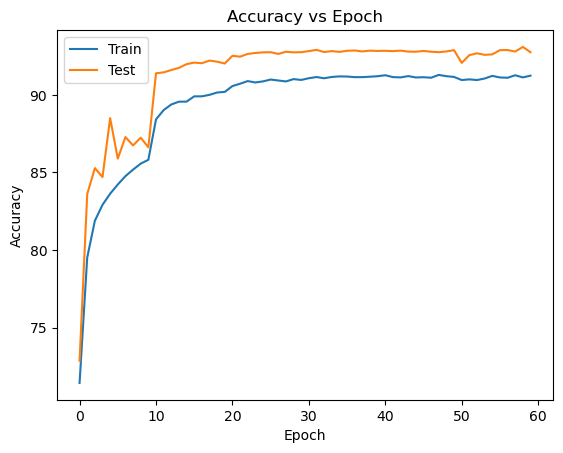

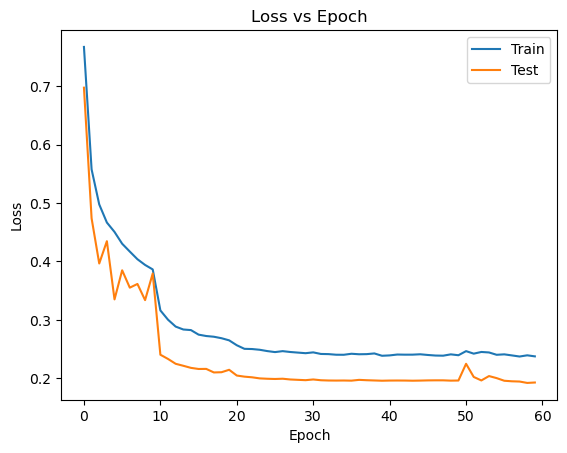

In [7]:
# 定义主函数
def test6():
    # 加载Fashion-MNIST数据集
    # train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor())
    # test_dataset = datasets.FashionMNIST(root='./data/', train=False, transform=transforms.ToTensor())
    # 使用transforms对数据集进行标准化
    # mean = train_dataset.data.float().mean() / 255
    # print(mean) # tensor(0.2860)
    # std = train_dataset.data.float().std() / 255
    # print(std) # tensor(0.3530)

    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        # transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,)),
        transforms.RandomErasing()
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.2860,), std=(0.3530,))
    ])
    # train_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=True, transform=transform_train)
    # test_dataset = datasets.FashionMNIST(root='/home/Akex/download/', download=False, train=False, transform=transform_test)
    train_dataset = datasets.FashionMNIST(root='./data/', download=False, train=True, transform=transform_train)
    test_dataset = datasets.FashionMNIST(root='./data/', download=False, train=False, transform=transform_test)
    # 定义模型
    model = resnet34(weights=None)  # 加载预训练模型
    num_classes = 10
    in_channels = 1  # 输入通道数为1
    model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 更改第一层卷积层
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # 更改最后一层全连接层

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    device = torch.device("cuda" if torch.cuda.is_available() else "mps")
    print(device)
    train_batch_size = 128
    test_batch_size = 100
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=12)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=12)

    model = model.to(device)
    model = torch.nn.DataParallel(model).cuda()
    train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []

    for epoch in range(60):
        if epoch == 50:
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
        # if epoch < 30:
        scheduler.step()
        test_loss, test_accuracy = test(model, device, test_loader, criterion)
        if (epoch + 1) % 2 == 0:
            if not os.path.exists('./checkpoints'):
                os.makedirs('./checkpoints/')
            # torch.save(model.state_dict(), '/home/Akex/LiGe-homework/homework2/checkpoints/checkpoint-{}-{}.pt'.format(epoch+1,test_accuracy))
            torch.save(model.state_dict(), './checkpoints/epo{}-acc{}.ckpt'.format(epoch+1,test_accuracy))
        print('Epoch {}: Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch + 1, train_loss, train_accuracy, test_loss, test_accuracy))

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    # 绘制精度曲线
    plt.plot(train_accuracies, label='Train')
    plt.plot(test_accuracies, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

    # 绘制损失曲线
    plt.plot(train_losses, label='Train')
    plt.plot(test_losses, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.legend()
    plt.show()


test6()